### 1. Importância da Visualização de Dados:
Explique a importância da visualização de dados no contexto de uma pandemia como a COVID-19. Como essas visualizações podem ajudar gestores de saúde pública e a população em geral a tomar decisões informadas?

É grande a quantidade de aplicações para a  visualização de dados no contexto de uma pandemia, entretanto podemos destacar:
- Mapear a evolução da doença observando acentuações nas curvas de contágio e óbito
- Comparar o padrão de evolução da doença em diferentes localidades.
- Segregar os dados e observar como diferentes aspectos sócio-econômicos são afetados pela pandemia.
- Utilizar dados da georeferenciados para criar mapas de calor, possibilitando observar aglutinações por proximidade.

### 2.Gráfico de Barras com Streamlit:
Usando os dados de casos novos de COVID-19 por semana epidemiológica de notificação, crie um gráfico de barras em Streamlit que mostre a evolução semanal dos casos em um determinado estado. Indique o estado escolhido e explique sua escolha.

streamlit run main_atv5.py --server.port=8501 --browser.serverAddress='74.249.85.195' --server.enableCORS false --server.enableXsrfProtection false

streamlit run main_atv2.py --server.port=8086 --browser.serverAddress='177.192.12.238'

In [ ]:
%pip install --upgrade geopy seaborn streamlit altair plotly

In [59]:
import pandas as pd
import glob

df = pd.concat([pd.read_csv(f, sep=";") for f in glob.glob('Dados/Covid/*.csv')], ignore_index=True)

#Criando colunas necessárias
df['data'] = pd.to_datetime(df['data'])
df['ano'] = df['data'].dt.year
df['mes'] = df['data'].dt.to_period('M').astype(str)

#Criando uma coluna que concatene a semana e o ano
df['semanaEpi'] = np.where(df['semanaEpi'] < 10, 
                           '0' + df['semanaEpi'].astype(str), 
                           df['semanaEpi'].astype(str))

df['semanaAno'] = df['ano'].astype(str) + '-' + df['semanaEpi']

#Retirando campos desnecessários
df = df.drop(columns=['semanaEpi','ano','coduf', 'codmun', 'codRegiaoSaude', 'nomeRegiaoSaude', 'interior/metropolitana','populacaoTCU2019','Recuperadosnovos','emAcompanhamentoNovos'])

#salvando o dataset unificado em um arquivo para recuperar posteriormente
df.to_csv('dados/covid.csv', index=False)

In [83]:
%%writefile main_atv2.py

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import streamlit as st
import seaborn as sns
from geopy.geocoders import Photon
import time
import altair as alt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#Agrupando o dataset para que eu tenha apenas um registro por semana e estado
uf = 'RJ'
df_plot = pd.read_csv('dados/covid.csv')
df_plot = df_plot[(df_plot['estado'] == uf)  & df_plot['municipio'].isnull()]
df_plot = df_plot[['semanaAno', 'casosNovos']].groupby(['semanaAno']).sum().reset_index()
df_plot = df_plot.sort_values('semanaAno')

st.write('### Selecionado o estado do RJ por ser o meu estado de residência')

#Plotando o gráfico
plt.figure(figsize=(12, 4))
plt.title(f'Novos casos de Covid-19 por semana no {uf} [Visão Incremental]')
plt.bar(df_plot['semanaAno'], df_plot['casosNovos'])
plt.ylabel('Casos Novos')
plt.xlabel('Semana Epidemológica')

#Ajustando os rótulos do eixo X para que não fiquem um por cima do outro
x_ticks = plt.gca().get_xticks()
x_labels = df_plot['semanaAno'].unique()
plt.xticks(x_ticks[::4], x_labels[::4], rotation=90, size=6)
st.pyplot(plt)

Overwriting main_atv2.py


### 3.Gráfico de Linha com Streamlit:
Crie um gráfico de linha utilizando Streamlit para representar o número de óbitos acumulados por COVID-19 ao longo das semanas epidemiológicas de notificação para todo o Brasil. Explique como a curva de óbitos acumulados pode ser interpretada.

In [47]:
#Agrupando o dataset para que eu tenha apenas um registro por semana no Brasil
regiao = 'Brasil'
df_plot = pd.read_csv('dados/covid.csv')
df_plot = df_plot[df_plot['regiao'] == regiao]
df_plot = df_plot[['semanaAno', 'obitosAcumulado']].groupby(['semanaAno']).max().reset_index()
df_plot = df_plot.sort_values('semanaAno')


st.write('### O abaixo gráfico apresenta o número de óbitos total no Brasil, desde o início da pandemia, separados por semana epidemiológica')

#Plotando o gráfico
plt.figure(figsize=(12, 4))
plt.title(f'Óbitos de Covid-19 no Brasil por Semana Epidemológica  [Visão Acumulada]')
sns.lineplot(x = df_plot['semanaAno'], y = df_plot['obitosAcumulado'])
plt.ylabel('Óbitos')
plt.xlabel('Semana Epidemológica')

#Ajustando os rótulos do eixo X para que não fiquem um por cima do outro
x_ticks = plt.gca().get_xticks()
x_labels = df_plot['semanaAno'].unique()
plt.xticks(x_ticks[::4], x_labels[::4], rotation=90, size=6)
st.pyplot(plt)

Overwriting main_atv.py


### 4.Gráfico de Área com Streamlit:
Utilizando os dados de casos acumulados por COVID-19, crie um gráfico de área em Streamlit para comparar a evolução dos casos em três estados diferentes. Explique as diferenças observadas entre os estados escolhidos.

In [45]:
#Agrupando o dataset
ufs = ['MG','RJ','ES']
df_plot = pd.read_csv('dados/covid.csv')
df_plot = df_plot[(df_plot['estado'].isin(ufs)) & df_plot['municipio'].isnull()]
df_plot = df_plot[['estado', 'mes', 'casosAcumulado']].groupby(['estado', 'mes']).max().reset_index()
df_plot= df_plot.sort_values('mes')


st.write('Comparativo entre RJ, ES e MG')
st.write('Se observa que uma curva de contágio semelhante entre os estados da região sudeste, apesar de MG apresentar uma aceleração maior no primeiro semestre de 2020. Também é possível observar um pico em janeiro de 2022 após festas de final de ano e a entrada em um platô a partir de janeiro de 2023.')

#Plotando o gráfico
plt.figure(figsize=(12, 4))
plt.title('Evolução dos casos de COVID-19 na região sudeste (Exceto SP)')
for estado in ufs:
    df_uf = df_plot[df_plot['estado'] == estado]
    plt.fill_between(df_uf['mes'].astype(str), df_uf['casosAcumulado'], label=estado, alpha=0.8)

plt.xticks(rotation=90)
plt.legend(title='Estado')
plt.tight_layout()
st.pyplot(plt)

Overwriting main_atv.py


### 5.Mapa com Streamlit:
Crie um mapa interativo utilizando a função st.map do Streamlit que mostre a distribuição dos casos acumulados de COVID-19 por município em um estado específico. Explique como esse tipo de visualização pode ajudar na análise geográfica da pandemia.

In [42]:
#Deixando guardada uma base com as coordenadas geográficas dos municípios do RJ

df = pd.read_csv('Dados\covid.csv')
df_plot = df[(df['data'] == max(df['data'])) & (df['estado'] == 'RJ')].copy()

geolocator = Photon(user_agent="measurements")

df_plot['latitude'],df_plot['longitude'] = None, None

for index, row in df_plot.iterrows():
    time.sleep(1) 
    location = geolocator.geocode(f"{row['municipio']}, Rio de Janeiro, Brazil", timeout=15)
    if location:
        df_plot.loc[index, 'latitude'] = location.latitude
        df_plot.loc[index, 'longitude'] = location.longitude

df_plot.to_csv('Dados\df_rj_lat_long.csv', index=False)

In [43]:
df_plot = pd.read_csv('Dados\df_rj_lat_long.csv')
df_plot = df_plot[df_plot['municipio'].notnull()]
df_plot = df_plot.dropna(subset=['latitude', 'longitude'])

#Reduzi o tamanho dos pontos para que não fiquem muito grandes
df_plot['size'] = (df_plot['casosAcumulado'] /  max(df_plot['casosAcumulado'])) * 10000


st.write("### Total de Casos por COVID-19")
st.write("Plotar dados georeferenciados pode auxiliar a observar aglutinações por proximidade.")
st.map(df_plot, latitude = 'latitude', longitude = 'longitude', size = 'size')

Overwriting main_atv.py


### 6.Visualização com Matplotlib:
Utilize a biblioteca Matplotlib para criar um gráfico de barras que mostre a comparação entre os casos novos e os óbitos novos de COVID-19 por estado na semana epidemiológica mais recente disponível. Explique o que os dados sugerem sobre a relação entre casos e óbitos.

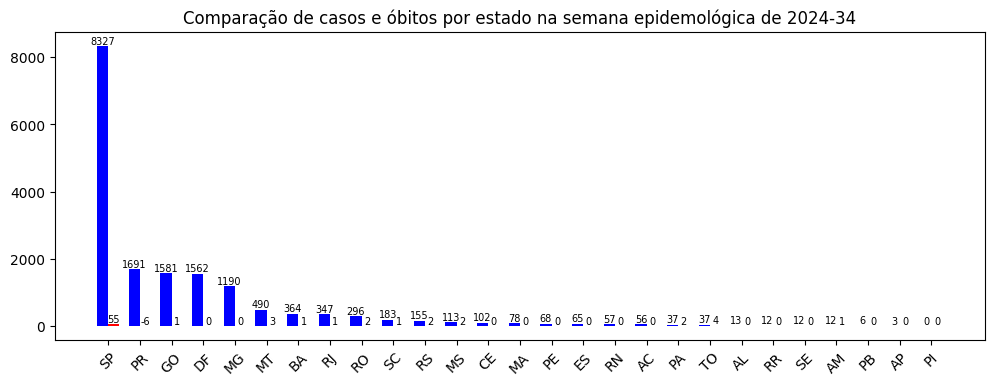

In [100]:
df_plot = pd.read_csv('dados/covid.csv')
#Total de cada estado
df_plot = df_plot[(df_plot['municipio'].isnull()) & (df_plot['estado'].notnull())]

#Selecionando a semana mais recente
semana = max(df_plot['semanaAno'])
df_plot = df_plot[df_plot['semanaAno'] == semana]

#Somar os casos da semana mais recente
df_plot = df_plot[['estado', 'semanaAno','casosNovos','obitosNovos']].groupby(['estado', 'semanaAno']).sum().reset_index()
df_plot = df_plot.sort_values('casosNovos', ascending=False)

st.write('Apesar de SP possuir o maior número de casos e de óbitos, não observei uma relação proporcional para os demais estados. Também é possível que os obitos observados sejam referentes aos casos de semanas anteriores.')

#Plotando o gráfico
plt.figure(figsize=(12, 4))
plt.title(f'Comparação de casos e óbitos por estado na semana epidemológica de {semana}')

# Posicionando as barras
x = range(len(df_plot['estado']))
largura = 0.35
barra_casos = plt.bar(x, df_plot['casosNovos'], width=largura, label='Casos Novos', color='blue')
barra_obitos = plt.bar([i + largura for i in x], df_plot['obitosNovos'], width=largura, label='Óbitos Novos', color='red')

# Adicionando rótulos de dados
for barra in barra_casos:
    altura = barra.get_height()
    plt.text(
        x = barra.get_x() + barra.get_width()/2, 
        y = altura, 
        s = altura,
        fontsize=7,
        ha='center', va='bottom'
        )

for barra in barra_obitos:
    altura = barra.get_height()
    plt.text(
        x = barra.get_x() + barra.get_width()/2, 
        y = altura, 
        s = altura,
        fontsize=7,
        ha='center', va='bottom'
        )

# Ajustando os rótulos do eixo X
plt.xticks([i + largura / 2 for i in x], df_plot['estado'], rotation=45)

plt.show()

### 7.Boxplot com Seaborn:
Usando a biblioteca Seaborn, crie um boxplot que compare a distribuição dos casos novos de COVID-19 por semana epidemiológica entre três regiões do Brasil (Norte, Nordeste, Sudeste). Explique as principais diferenças observadas.

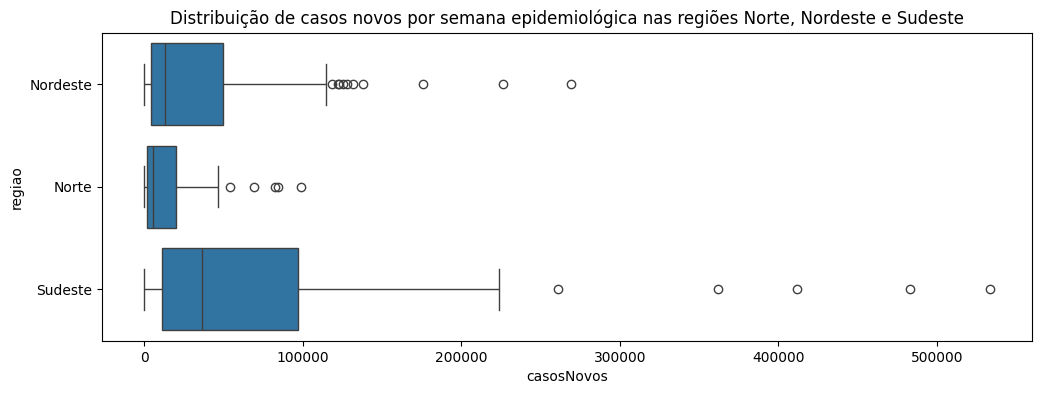

In [137]:
df_plot = pd.read_csv('dados/covid.csv')
#Filtrando apenas as regiões desejadas
df_plot = df_plot[df_plot['regiao'].isin(['Norte','Nordeste','Sudeste'])]
#Deixando apenas o total de cada estado
df_plot = df_plot[df_plot['municipio'].isnull()]
#Retirei os valores negativos pois se tratam de correções sobre o calculo acumulado, não existindo notificação negativa.
df_plot = df_plot[df_plot['casosNovos'] >= 0]

#Agregando por região
df_plot = df_plot[['regiao', 'semanaAno','casosNovos']].groupby(['regiao', 'semanaAno']).sum().reset_index()

st.write('Se observa um grande contraste entre o número de casos reportados semanalmente na região Sudeste e as demais regiões. A diferença é tão expressiva que a mediana da região sudeste quase alcança o terceiro quartil do Nordeste e o limite superior da região Norte. Entretanto, esse plot não é adequado para comparar o nível epidêmico em cada região, pois a população das 3 regiões é bem distinta (Sudeste ~84Mi, Nordeste ~54Mi, Norte ~17Mi). Para uma comparação mais adequada deveria ser calculada a proporção de casos em relação à população total de habitantes de cada região, por exemplo, o número de casos a cada mil habitantes.')

#criando um boxplot com seaborn
plt.figure(figsize=(12, 4))
plt.title(f'Distribuição de casos novos por semana epidemiológica nas regiões Norte, Nordeste e Sudeste')
sns.boxplot(data=df_plot, x='casosNovos', y='regiao')
plt.show()

### 8.Gráfico de Área com Altair:
Crie um gráfico de área em Altair para mostrar a evolução dos casos novos de COVID-19 por semana epidemiológica de notificação em uma determinada região do Brasil. Explique a escolha da região e as tendências observadas nos dados.

In [1]:
import matplotlib.pyplot as plt
import altair as alt
import pandas as pd
import streamlit as st

In [17]:
#Agrupando o dataset para que eu tenha apenas um registro por semana e estado
df_plot = pd.read_csv('dados/covid.csv')
df_plot = df_plot[(df_plot['regiao'] == 'Sudeste') & (df_plot['municipio'].isnull())]
df_plot = df_plot[['estado','semanaAno', 'casosNovos']].groupby(['estado','semanaAno']).sum().reset_index()
df_plot = df_plot.sort_values('semanaAno')

st.write('### Seguindo o padrão dos exercícios anteriores, selecionei o Sudeste por ser a região onde resido')
st.write('Se observa que São Paulo, em parte pelo tamanho de sua população, se manteve com número de contágio semanal bem superior às demais UFs desde o começo da pandemia, inclusive, tendo uma aceleração de contágio mais agravada do que as outras UFs entre o início da pandemia e a semana 33 de 2020. O mesmo comportamento pode ser observado novamente entre a semana 1 (pós festas) e a semana 24 de 2021. Apesar disso, se manteve controlada nas semanas 3 a 6 de 2022, enquanto RJ e MG apresentaram o maior pico histórico, com mais de 160mil novos casos, superando até mesmo a máxima histórica de 120mil casos em SP. Após este pico, todos os UFs entraram em declínio do número de casos, e apesar da diferença populacional, todas se mantiveram em um patamar similar, demonstrando um melhor controle da pandemia no estado de SP em relação às demais UFs.')

#Plotando o gráfico de área com altair
alt.Chart(df_plot).mark_area().encode(
    x=alt.X('semanaAno:N', 
            axis=alt.Axis(labelOverlap='greedy') #Ajustei para que os rótulos não se sobreponham
            ),
    y=alt.Y('casosNovos:Q', stack=None),
    color=alt.Color('estado:N', legend=alt.Legend(title='Estado')),
    opacity=alt.value(0.7),
    tooltip=['estado:N', 'semanaAno:O', 'casosNovos:Q']
).properties(
    title='Novos casos de Covid-19 por semana na região Sudeste',
    width=1000,
    height=400,
)

2024-09-01 20:44:28.283 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-01 20:44:28.306 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-01 20:44:28.310 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-01 20:44:28.310 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


alt.Chart(...)

<Figure size 1200x400 with 0 Axes>

### 9.Heatmap com Altair:
Desenvolva um heatmap em Altair que mostre a correlação entre casos novos, óbitos novos e leitos hospitalares ocupados (caso os dados estejam disponíveis) em um determinado estado. Explique as possíveis correlações observadas.

In [76]:
df_plot = pd.read_csv('dados/covid.csv')
df_plot = df_plot[(df_plot['estado'] == 'RJ') & (df_plot['municipio'].isnull())]

#Tratei os valores negativos pois se tratam de correções sobre o calculo acumulado, não existindo notificação negativa.
df_plot['casosNovos'] = np.where(df_plot['casosNovos'] < 0, 0, df_plot['casosNovos'])
df_plot['data'] = pd.to_datetime(df_plot['data'])
df_plot['trimestre'] = df_plot['data'].dt.to_period('Q').astype(str)

st.write('A base de leitos hospitalares não estava disponível no DataSus, portanto prossegui com uma correlação entre casos e óbitos por mês. Em 2021 é possível observar um agravamento do número de óbitos de acordo com a número de novos casos, situação que já não ocorre mais a partir de janeiro de 2022, momento em que a grande massa da população do Rio de Janeiro já havia recebido a primeira dose de vacina.')

alt.Chart(df_plot).mark_rect().encode(
    x=alt.X('trimestre:N', sort='ascending'),
    y=alt.Y('casosNovos:O', sort='descending').bin(maxbins=100),
    color='obitosNovos:Q'
).properties(
    title='Correlação entre casos e óbitos por quarter no RJ',
    width=400,
    height=400,
)


2024-09-01 22:13:59.032 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-01 22:13:59.039 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-01 22:13:59.042 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-01 22:13:59.043 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


alt.Chart(...)

### 10.Gráfico de Pizza com Plotly:
Usando Plotly, crie um gráfico de pizza (pie chart) que mostre a distribuição percentual dos casos acumulados de COVID-19 entre as cinco regiões do Brasil. Explique o que os dados revelam sobre a distribuição geográfica dos casos.

In [5]:
df_plot = pd.read_csv('dados/covid.csv')

df_plot = df_plot[df_plot['regiao'] != 'Brasil']
df_plot = df_plot[df_plot['municipio'].isnull()]

#Pegando a última data
df_plot = df_plot[df_plot['data'] == max(df_plot['data'])]
df_plot = df_plot[['regiao', 'casosAcumulado']].groupby('regiao').sum().reset_index()

#Criando os rótulos com abreviação da região e percentual
df_plot['perc'] = df_plot['casosAcumulado'] / sum(df_plot['casosAcumulado'])
df_plot['perc'] = (df_plot['perc']*100).round().astype(int).astype(str) + '%'
df_plot['round'] = round(df_plot['casosAcumulado'] / 1000000, 2)

cmap = {
    'Norte': 'N',
    'Nordeste': 'NE',
    'Centro-Oeste': 'CO',
    'Sudeste': 'SE',
    'Sul': 'S'
}

df_plot['regiao'] = df_plot['regiao'].replace(cmap)
df_plot['label'] = df_plot['regiao'] + ': ' + df_plot['round'].astype(str) + 'Mi'
df_plot.sort_values('casosAcumulado', ascending=False, inplace=True)

st.write('Se observa que a região sudeste concentrou 40% de todos os casos de Covid no Brasil, praticamente o dobro da região sul, a segunda colocada. Se compararmos ao número de habitantes de cada região, o número de casos no Sul é equivalente a 27% de sua população (~30Mi hab.), enquanto no Sudeste é equivalente a 17% (~85Mi hab.) e no Nordeste 14% (55Mi hab.).')

#Criando gráfico de pizza com altair
base = alt.Chart(df_plot).encode(
    alt.Theta("casosAcumulado:Q").stack(True),
    alt.Color("regiao:N").legend(None),
    alt.Order("casosAcumulado:Q")
).properties(
    title='Total de casos por região',
    width=400, height=400
)

#Adicionando os rótulos
pie = base.mark_arc(outerRadius=100)
label = base.mark_text(radius=130, size=10).encode(text="label:N")
perc = base.mark_text(radius=80, size=10).encode(text="perc:N", color=alt.value("white"))

pie + label + perc

2024-09-01 23:20:40.687 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-01 23:20:41.063 
  command:

    streamlit run C:\Users\RodrigoPintoMesquita\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py [ARGUMENTS]
2024-09-01 23:20:41.066 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-01 23:20:41.072 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-01 23:20:41.074 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


alt.LayerChart(...)

### 11.Subplots com Plotly:
Crie subplots em Plotly que mostrem, lado a lado, gráficos de barras comparando os casos novos e os óbitos novos de COVID-19 por semana epidemiológica em duas diferentes regiões do Brasil. Explique as diferenças observadas entre as regiões.

In [84]:
df_plot = pd.read_csv('dados/covid.csv')
#Total de cada estado
df_plot = df_plot[(df_plot['municipio'].isnull()) & (df_plot['regiao'].isin(['Sul','Sudeste']))]

#Agrupando e tratando valores negativos
df_plot = df_plot[['regiao', 'semanaAno','casosNovos','obitosNovos']].groupby(['regiao', 'semanaAno']).sum().reset_index()
df_plot['casosNovos'] = np.where(df_plot['casosNovos'] < 0, 0, df_plot['casosNovos'])
df_plot['obitosNovos'] = np.where(df_plot['obitosNovos'] < 0, 0, df_plot['obitosNovos'])
df_plot = df_plot.sort_values('semanaAno', ascending=True)

df_se = df_plot[df_plot['regiao'] == 'Sudeste']
df_su = df_plot[df_plot['regiao'] == 'Sul']

st.write('Em números absolutos de novos casos se observam curvas semelhantes para as regiões sul e sudeste. Para óbitos se observa um patamar elevado para o Sudeste no início da pandemia, que se mantém durante todo o primeiro semestre de 2021, representando aproximadamente o dobro de óbitos por semana em relação à região sul, o mesmo volta a ocorrer no primeiro semestre de 2022. Também se observa que ambas as regiões apresentam os mesmos períodos de picos, com picos de contaminação em outubro 2021 e abril 2022, sendo seguidos por picos de óbitos nos meses seguintes, em dezembro 2021 e julho 2022.')

#Plotando gráfico com Altair
fig = make_subplots(rows=1, cols=2)

#-----------Gráfico 1---------------
#Sudeste
fig.add_trace(
    go.Bar(name='Sudeste', x=df_se["semanaAno"], y=df_se["casosNovos"], yaxis='y', offsetgroup=1),
    row=1, col=1
)
#Sul
fig.add_trace(
    go.Bar(name='Sul', x=df_su["semanaAno"], y=df_su["casosNovos"], yaxis='y', offsetgroup=2),
    row=1, col=1
)

#-----------Gráfico 2---------------
#Sudeste
fig.add_trace(
    go.Bar(name='Sudeste', x=df_se["semanaAno"], y=df_se["obitosNovos"], yaxis='y2', offsetgroup=1),
    row=1, col=2
)
#Sul
fig.add_trace(
    go.Bar(name='Sul', x=df_su["semanaAno"], y=df_su["obitosNovos"], yaxis='y2', offsetgroup=2),
    row=1, col=2
)

fig.update_layout(barmode='group',
                  title_text='Comparativo de Covid-19 entre Sul e Sudeste por semana epidemológica',
                  yaxis_title='Casos',
                  yaxis2_title='Óbitos')

fig.show()

In [ ]:
#teste

### 12.Mapa Interativo com PyDeck:
Utilize PyDeck para criar um mapa interativo que mostre a densidade populacional ajustada para os casos acumulados de COVID-19 por município em uma determinada região do Brasil. Explique como a densidade populacional pode influenciar a disseminação da COVID-19.